# Fit simple models predicting smoothed female velocity from surrogate neural activity.

Using ridge regression

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import linear_model
import sys

from disp import set_plot
from my_torch import skl_fit_ridge

cc = np.concatenate

MAX_TR = 276
NTR = 50
NTRAIN = int(round(.8*NTR))
NSPLIT = 30

FIT_LIN = skl_fit_ridge
FIT_KWARGS = {'alpha': 10}

In [2]:
# NRL_MDL = 'lin'  # linear neural model
# NRL_MDL = 'ln'  # linear-nonlinear model
NRL_MDL = 'dyn'  # dynamical neural model

DF_BAKER_FIT_PARAM = pd.read_csv(f'data/simple/neur/baker_{NRL_MDL}_fit_param.csv') 

ROI_SET, R_COLS_USE = 'all', [f'R_{ir}' for ir in DF_BAKER_FIT_PARAM.EXPT_ID]
# ROI_SET, R_COLS_USE = 'nonsoma', [f'R_{ir}' for ir in DF_BAKER_FIT_PARAM.EXPT_ID][DF_BAKER_FIT_PARAM.ROI != 'somas']
# ROI_SET, R_COLS_USE = 'soma', [f'R_{ir}' for ir in DF_BAKER_FIT_PARAM.EXPT_ID][DF_BAKER_FIT_PARAM.ROI == 'somas']

TARGS = ['FFV_MN_60', 'FFV']

PFX_BHV_0 = f'data/simple/mlv_c/neur_basic/c_baker_{NRL_MDL}/mlv_c_baker_{NRL_MDL}'
PFX_BHV_1 = f'data/simple/behav_xtd/behav_xtd'

SAVE_FILE = f'data/simple/mlv_c/neur_basic/c_baker_{NRL_MDL}_{ROI_SET}_{TARGS[0].lower()}_{NTR}_tr.npy'

DF_BAKER_FIT_PARAM

,EXPT_ID,LINE,FLY,ROI,ROI_USED,FIT_ERR,SUCCESS,T_0,R_0,TAU_R,TAU_A,X_S,X_P
0,0,R70G01,0,somas,False,0.275200,True,-0.000000,0.028882,6.202615,30.336758,-4.958290,-2.597432
1,1,R70G01,1,somas,False,0.186212,True,0.117647,0.025128,3.835468,21.821295,-4.163967,-1.472075
2,2,R70G01,2,somas,False,0.248414,True,-0.000000,0.055962,6.017162,15.058055,-6.248007,-2.095952
3,3,R70G01,3,somas,False,0.455963,True,-0.000000,-0.014227,6.016828,11.820576,-5.679735,-2.118245
4,4,R70G01,4,somas,False,0.229018,True,-0.000000,0.019831,6.434825,55.496220,-4.415761,-2.863647
...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,219,VT34811,0,somas,False,0.276087,True,-0.000000,0.039119,1.799608,1440.994269,-0.049828,2.494657
220,220,VT34811,0,ascending projection,False,0.037801,True,-0.000000,-0.001886,1.298841,27.643238,0.098451,2.457383
221,221,vPN1_split,0,somas,False,0.404112,True,-0.588235,-0.014702,4.151226,6.155551,8.332263,2.353217
222,222,vPN1_split,1,somas,False,1.205977,True,0.235294,-0.095665,5.924070,90.705238,2.390705,0.604586


In [3]:
# fit regression models
rslts = []
for csplit in range(NSPLIT):
    print(f'Split {csplit}')
    rnd_tr_idxs = np.random.permutation(MAX_TR)
    idxs_train = rnd_tr_idxs[:NTRAIN]
    idxs_test = rnd_tr_idxs[NTRAIN:NTR]
    if csplit < 2:
        rslt = FIT_LIN([PFX_BHV_0, PFX_BHV_1], R_COLS_USE, TARGS, idxs_train, idxs_test, return_y=True, **FIT_KWARGS)
    else:
        rslt = FIT_LIN([PFX_BHV_0, PFX_BHV_1], R_COLS_USE, TARGS, idxs_train, idxs_test, return_y=False, **FIT_KWARGS)
    rslts.append(rslt)

Split 0
Loading...
Fitting...
>>Split 1
Loading...
Fitting...
>>Split 2
Loading...
Fitting...
>>

In [11]:
rslts[0].r2_train

{'FFV_MN_60': 0.39503984600036335, 'FFV': 0.01753942749670323}

In [12]:
save_data['r2_train']

{'FFV_MN_60': array([0.39503985, 0.38745404, 0.64448112]),
 'FFV': array([0.01753943, 0.02494225, 0.06987223])}

In [13]:
# save r2, weights, and example predictions
save_data = {
    'r2_train': {targ: np.array([rslt.r2_train[targ] for rslt in rslts]) for targ in TARGS},
    'r2_test': {targ: np.array([rslt.r2_test[targ] for rslt in rslts]) for targ in TARGS},
    'w': {targ: np.array([rslt.w[targ] for rslt in rslts]) for targ in TARGS},
    'ys_train': {targ: [rslt.ys_train[targ] for rslt in rslts[:2]] for targ in TARGS},
    'ys_test': {targ: [rslt.ys_test[targ] for rslt in rslts[:2]] for targ in TARGS},
    'y_hats_train': {targ: [rslt.y_hats_train[targ] for rslt in rslts[:2]] for targ in TARGS},
    'y_hats_test': {targ: [rslt.y_hats_test[targ] for rslt in rslts[:2]] for targ in TARGS},
    'targs': TARGS,
    'fit_fn': FIT_LIN.__name__,
    'fit_kwargs': FIT_KWARGS,
    'ntr': NTR,
    'nsplit': NSPLIT,
    'nr': len(R_COLS_USE)
}

np.save(SAVE_FILE, np.array([save_data]))

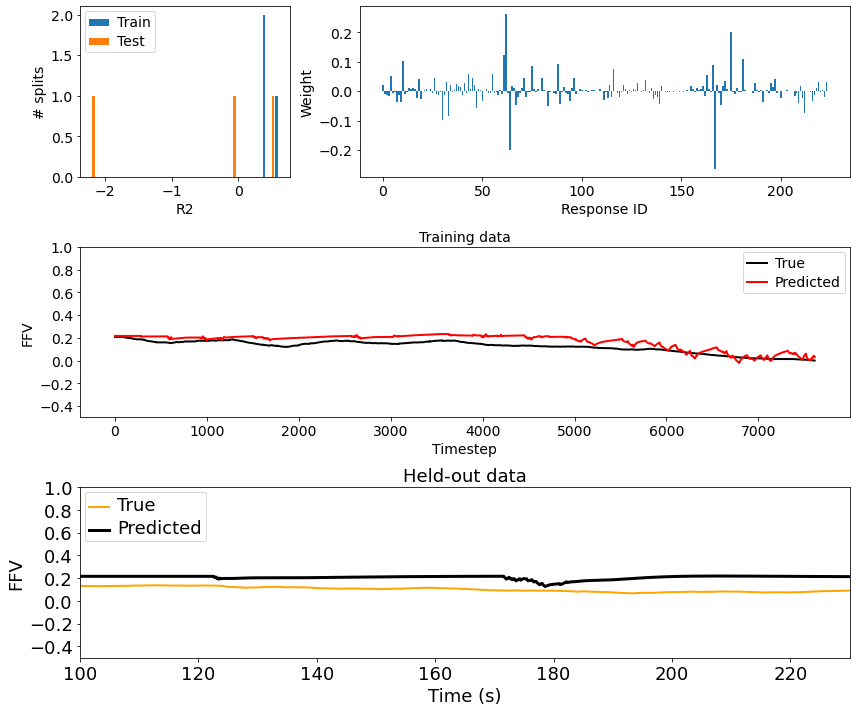

In [14]:
TRAIN_IDX_PLOT = 0
TEST_IDX_PLOT = 0

data = np.load(SAVE_FILE, allow_pickle=True)[0]
gs = gridspec.GridSpec(3, 3)
fig = plt.figure(figsize=(12, 10), tight_layout=True)
axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1:]), fig.add_subplot(gs[1, :]), fig.add_subplot(gs[2, :])]

axs[0].hist(np.transpose([data['r2_train'][TARGS[0]], data['r2_test'][TARGS[0]]]), bins=30)
axs[0].legend(['Train', 'Test'])
set_plot(axs[0], x_label='R2', y_label='# splits', font_size=14)

axs[1].bar(np.arange(data['w'][TARGS[0]].shape[1]), np.mean(data['w'][TARGS[0]], axis=0))
set_plot(axs[1], x_label='Response ID', y_label='Weight', font_size=14)

axs[2].plot(np.arange(len(data['ys_train'][TARGS[0]][0][TRAIN_IDX_PLOT])), data['ys_train'][TARGS[0]][0][TRAIN_IDX_PLOT], c='k', lw=2)
axs[2].plot(np.arange(len(data['y_hats_train'][TARGS[0]][0][TRAIN_IDX_PLOT])), data['y_hats_train'][TARGS[0]][0][TRAIN_IDX_PLOT], c='r', lw=2)
axs[2].legend(['True', 'Predicted'])
set_plot(axs[2], y_lim=(-.5, 1), x_label='Timestep', y_label='FFV', title='Training data', font_size=14)

axs[3].plot(np.arange(len(data['ys_test'][TARGS[0]][0][TEST_IDX_PLOT]))/30.03, data['ys_test'][TARGS[0]][0][TEST_IDX_PLOT], c='orange', lw=2)
axs[3].plot(np.arange(len(data['y_hats_test'][TARGS[0]][0][TEST_IDX_PLOT]))/30.03, data['y_hats_test'][TARGS[0]][0][TEST_IDX_PLOT], c='k', lw=3)
axs[3].legend(['True', 'Predicted'], loc='upper left')
set_plot(axs[3], x_lim=(100, 230), y_lim=(-.5, 1), x_label='Time (s)', y_label='FFV', title='Held-out data', font_size=18)